# Install and import libraries

In [ ]:
!pip install transformers
!pip install datasets
!pip install shap
!pip install pysbd
!pip install evaluate
!pip install rouge_score

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_dataset
from collections import Counter
from functools import reduce
import matplotlib.pyplot as plt
from spacy import displacy
import pandas as pd
import tqdm
import pysbd
import shap
import evaluate
import en_core_web_sm
import seaborn as sns


ner_tagger = en_core_web_sm.load()

# Load Dataset

In [ ]:
DATASET_NAME, DATASET_VERSION = 'cnn_dailymail', '3.0.0'
TRAIN_SIZE = 1000
VALIDATION_SIZE = 100
TEST_SIZE = 50

In [ ]:
dataset = load_dataset(DATASET_NAME, DATASET_VERSION)

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset['train'] = dataset['train'].select(range(TRAIN_SIZE))
dataset['validation'] = dataset['validation'].select(range(VALIDATION_SIZE))
dataset['test'] = dataset['test'].select(range(TEST_SIZE))

# Data exploratory analysis

## Character distributions

In [ ]:
def character_distribution(dataset, feature_name, dataset_split = 'train', progressbar = True):

    assert dataset_split in dataset.keys()

    print('Counting characters for each article')
    character_counters = list(map(lambda x: Counter(x[feature_name]), tqdm.tqdm(dataset[dataset_split], position=0, leave=True) if progressbar else dataset[dataset_split]))

    print(100 * '-')
    
    print('Combining character frequencies')
    characters_distribution = reduce(lambda x, y: x + y, tqdm.tqdm(character_counters, position=0, leave=True) if progressbar else character_counters, Counter())

    return characters_distribution

### Character distribution in source sentences

In [ ]:
src_character_distribution = character_distribution(dataset=dataset, feature_name='article', dataset_split='train')

Counting characters for each article


100%|██████████| 287113/287113 [01:29<00:00, 3222.83it/s]


----------------------------------------------------------------------------------------------------
Combining character frequencies


100%|██████████| 287113/287113 [00:50<00:00, 5667.22it/s]


In [ ]:
df = pd.DataFrame(src_character_distribution.items(), columns=['letter', 'frequency'])
df.sort_values(by=['frequency'], ascending=False, inplace=True)
pd.set_option('display.max_rows', None)
df.head(df.shape[0])

letter  frequency
5           198374876
14       e  110213170
16       t   76541405
10       a   75935698
24       o   65760642
25       i   63934679
7        n   62800248
18       s   57745492
17       r   56997274
37       h   44878880
9        l   36671732
11       d   36100106
26       c   25684605
15       u   23342033
32       m   20341464
27       f   18712908
8        g   18466318
28       p   17070839
41       w   16211782
22       y   15509287
40       b   12771837
36       .   12042106
4        ,    9473933
48       v    9072963
46       k    6913473
42       '    4945066
45       T    3555774
60       S    3352678
20       -    3035144
49       A    2865380
47       I    2765515
50       C    2540911
31       0    2513605
39       M    2493993
55       B    2137493
35       1    1887242
21       H    1684170
43       "    1666868
23       P    1651008
44       x    1568428
30       2    1528904
3        D    1486546
57       W    1453793
2        N    1441612
52       :    1436094
0        L    1251318
6        E    1222384
13       R    1195855
64       F    1142790
62       j    1138450
343      ’     998409
65       G     973754
1        O     922481
59       J     870949
56       z     838257
53       U     778541
71       3     725537
54       K     678098
70       5     671123
61       q     640764
69       9     613575
34       4     576003
305      ‘     509800
19       )     497141
12       (     492475
76       6     459317
38       8     429553
63       7     421401
51       V     407540
66       Y     327582
163            244950
29       £     186832
68       ?     179143
33       $     137618
215      –     115496
75       Q     106622
78       Z     105195
72       ;      77605
67       !      70829
110      |      59042
101      *      52614
77       /      45511
84       X      39671
91       %      37162
171      —      35872
73       [      34097
74       ]      33958
82       &      31354
158      ”      17710
223      “      16287
94       @      13926
115      #      11449
79       é      10365
58       »      10350
221      …       8182
321              7572
102      +       6583
85       •       6369
95       €       5696
90       _       4081
134      â       4056
187      ¿       3790
88       ©       3257
112      =       2136
100      ñ       1730
96       °       1689
162      Ã       1667
159      Â       1635
107      ­       1515
99       á       1403
204      ™       1335
86       ½       1289
92       í       1123
98       è       1009
125      ö       1005
83       ü        908
93       ó        789
106      `        705
111      ç        701
120      ä        477
198      ‏        463
104      ø        352
81       ú        302
117      \        288
97       ï        286
119      >        284
80       ã        273
113      à        269
108      }        253
161      ¬        251
191     \r        246
286      {        244
121      ë        243
87       ô        238
160      ‚        234
309      ​        216
165      ±        212
124      É        211
174      ·        210
308      ■        195
227      ‎        177
122      ¢        172
183      ‪        159
128      å        157
184      ′        142
131      Ö        142
151      ¹        135
147      ¼        121
182      ‬        119
258      ˜        113
148      <        110
127      ê        109
118      ¥        105
89       ®        103
114      Á        102
167      ²        100
314      ﻿         96
135      ×         94
315      ﬁ         91
116      ´         90
231      ●         85
105      º         84
149      ~         83
202      ć         83
164      §         82
133      ¡         81
173      ¨         77
170      ¯         74
259      ‑         69
192      ı         67
166      ³         66
195      š         63
344      ‭         61
129      æ         59
303      ‐         58
216      ð         55
345      ÷         54
145      ł         53
253      ğ         50
130      Ó         49
338      ā         47


In [ ]:
df.describe()

### Character distribution in target sentences

In [ ]:
trg_character_distribution = character_distribution(dataset=dataset, feature_name='highlights', dataset_split='train')

Counting characters for each article


100%|██████████| 287113/287113 [00:25<00:00, 11118.57it/s]


----------------------------------------------------------------------------------------------------
Combining character frequencies


100%|██████████| 287113/287113 [00:22<00:00, 13045.29it/s]


In [ ]:
df = pd.DataFrame(trg_character_distribution.items(), columns=['letter', 'frequency'])
df.sort_values(by=['frequency'], ascending=False, inplace=True)
df.head(df.shape[0])

letter  frequency
4            13701119
8        e    7889248
1        a    5683292
7        t    4990689
12       i    4757356
6        o    4737545
11       n    4616065
9        s    4509750
2        r    4390899
13       l    2819224
24       h    2745103
15       d    2660388
16       c    1924183
23       u    1699551
33       m    1496034
17       f    1391309
18       g    1331792
30       p    1267082
3        y    1127218
27       .    1103491
31       w    1078553
35       b     943369
28      \n     800992
34       v     655289
48       k     529674
43       ,     439629
32       '     381590
38       S     308452
60       T     263479
21       0     247545
41       C     246406
55       A     231120
22       M     222588
51       -     220472
54       B     182427
25       1     172160
5        P     160549
0        H     156050
20       2     139134
61       x     130405
45       I     123974
42       N     123529
40       W     120682
10       D     119928
53       F     117875
14       R     117079
39       L     116308
47       E     100943
59       G      96624
46       j      88539
36       "      87038
37       J      84468
66       O      78399
65       z      74626
50       3      70260
52       5      69169
58       U      67154
69       K      65489
62       4      59030
70       9      56063
44       :      48259
67       6      47300
57       q      45056
63       7      42583
26       8      42214
56       V      40681
138             29754
19       £      23699
29       Y      23183
64       $      16458
73       Z      10486
68       Q      10474
149      ’       9824
49       ;       8370
81       %       6946
79       )       5425
78       (       5412
92       *       4014
150      ‘       3724
83       X       3712
76       ?       3701
72       /       2742
80       &       2456
77       !       1555
152      –        947
75       é        828
120      #        606
89       +        320
82       @        303
88       ]        287
87       [        280
86       €        229
102      °        170
112      Â        170
126      —        162
93       ñ        140
91       á        107
151                97
71       ü         81
96       ö         77
103      ó         73
74       í         69
84       ½         67
85       è         63
101      â         61
125      ”         42
111      ç         41
158      …         40
106      ­         39
156      “         37
115      Ã         36
134      =         33
97       ø         31
100      ã         31
123      ä         30
108      _         28
116      ©         25
133      ë         24
99       ú         18
155      }         17
153      {         17
128      ï         16
173      ™         14
130      à         14
110      ô         12
113      ‚         12
114      ¬         12
135      É         10
104      Á          9
166      Ö          8
98       å          8
90       |          7
160      ć          7
161      ~          7
94       ¥          6
148      `          6
194      ​          6
165      ā          6
136      ˚          6
168      ž          6
122      ł          6
167      ‑          5
179      š          5
140      Ó          5
159      č          5
164      ê          5
109      ¹          5
186      >          5
154      \          5
131      <          5
95       ¼          5
157      î          4
127      ²          4
213      ğ          4
137      õ          4
107      ¾          4
180      ‎          4
188      ″          4
199      р          3
190      ă          3
146      º          3
196      н          3
197      т          3
224      π          2
182      ř          2
187      Ł          2
189      ń          2
175      ‪          2
210      Λ          2
198      е          2
177      ş          2
201      а          2
176      ð          2
214      Ì          2
230      Ż          2
170      Å          2
124      ¢          2
129      ō          2
132      ±          2
119      ´          2
145      Ä          2


In [ ]:
pd.set_option('display.max_rows', 20)
df.describe()

frequency
count     128.000000
mean    28000.343750
std     75496.017793
min         1.000000
25%         5.000000
50%      1758.500000
75%     10250.000000
max    584652.000000

## Compare lengths of the input and target sentences

In [ ]:
dataset_split = 'train'

In [ ]:
src_lengths = list(map(lambda x: len(x['article']), tqdm.tqdm(dataset[dataset_split], position=0, leave=True)))
trg_lengths = list(map(lambda x: len(x['highlights']), tqdm.tqdm(dataset[dataset_split], position=0, leave=True)))

100%|██████████| 287113/287113 [00:13<00:00, 20692.90it/s]


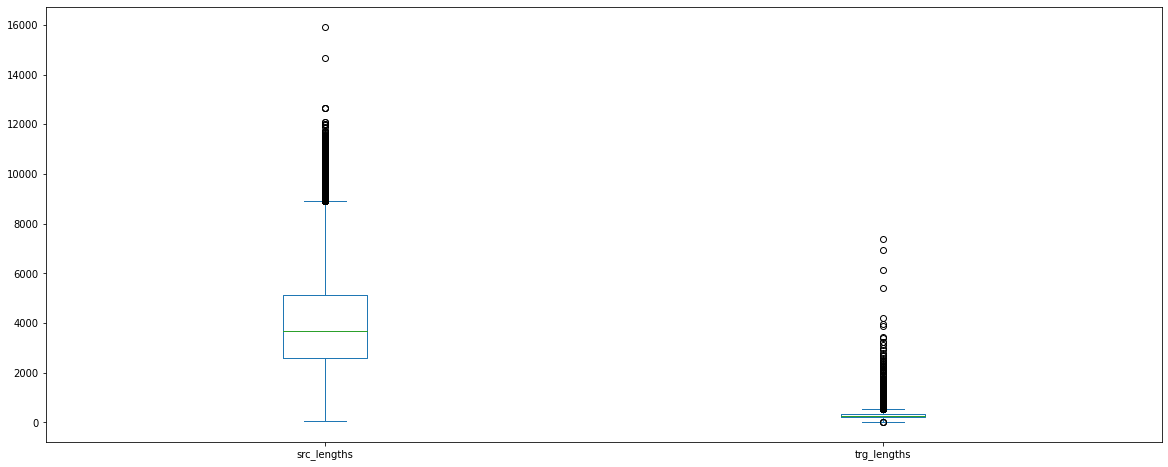

In [ ]:
pd.DataFrame(data={'src_lengths':src_lengths, 'trg_lengths':trg_lengths}).plot(kind='box', figsize=(20, 8))

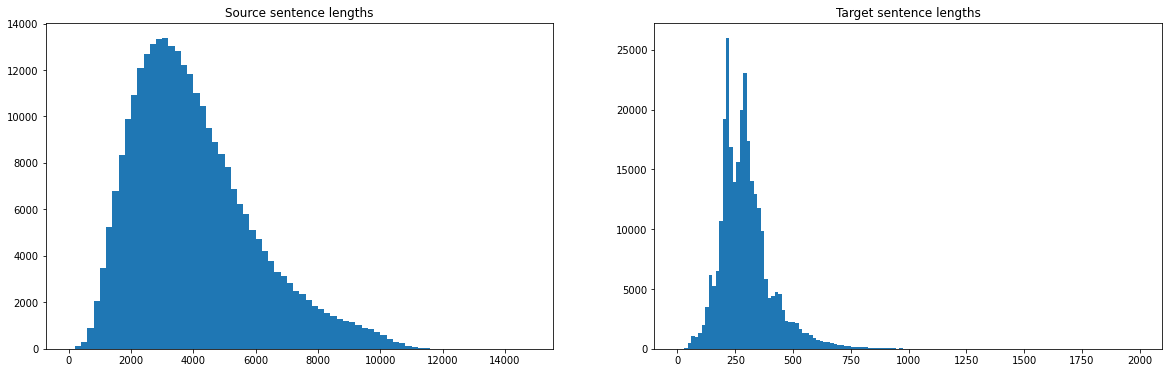

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].hist(src_lengths, bins = range(0, 15_000, 200))
ax[0].set_title('Source sentence lengths')

ax[1].hist(trg_lengths, bins = range(0, 2000, 15))
ax[1].set_title('Target sentence lengths')

plt.show()
plt.clf()

## Find characters that are in source sentence, but not in target

In [ ]:
unmatched_characters_list = [src_char for src_char in src_character_distribution.keys() if not (src_char in trg_character_distribution.keys())]

In [ ]:
print(unmatched_characters_list)

['»', '®', 'ò', '^', 'ÿ', 'þ', 'Ü', 'Ś', 'ś', 'Ê', '§', '„', '·', 'Ţ', 'Ħ', 'ġ', 'ħ', '‰', '\u202c', '¶', 'Ñ', '¿', 'ª', 'ย', 'พ', '\r', 'ง', 'Ë', '\u200f', '¸', 'Ÿ', 'ż', 'ě', 'ī', 'Đ', 'ì', 'ấ', 'ạ', 'Ō', 'ʻ', 'Æ', '¤', '†', 'Č', '−', 'Ô', 'Œ', '˝', '⅛', '●', '门', '外', '有', '个', '世', '界', '（', '）', '心', '中', '声', '音', '四', '方', '等', '你', '来', '呀', '游', '女', '₩', 'บ', '\u202f', '˜', 'ˆ', 'Ð', '▼', '▲', '‡', 'ا', 'ل', 'ر', 'ت', 'ب', 'م', 'ي', 'ك', 'ف', 'ح', 'ج', 'ة', '钱', '没', '，', '回', '家', '过', '年', 'µ', '♥', 'ő', '\uf022', '¦', 'À', 'Ş', 'ň', 'л', 'о', 'б', 'д', 'ы', '‐', '‹', '̈', '■', 'ả', 'È', 'ź', '⅔', '\ufeff', 'ﬁ', '\u200a', 'ʼ', '⅓', '\u2028', 'Ι', '\uf06e', '春', '節', '農', '曆', '新', '❤', '️', 'ش', 'أ', 'و', 'س', '―', 'ế', '\u2005', '̄', 'Ḥ', 'ṣ', '\u202d', '÷', '█', '‟', 'О', '⁰', 'ϟ', 'Ƙ', 'Ʀ', 'ן', '∑', 'β', '\u2029', 'ﬂ', '\t', '⁄', 'в', 'м', 'с', '∙', 'ﬀ', '縄', '縯', '́', '̧', '😳', '★', '̀', 'τ', 'ὴ', 'ν', 'ά', 'ε', 'ς', 'μ', 'ώ', 'ο', 'ρ', 'ι', 'κ', 'ί', 'α', 'Þ', '\u200d

## Better understending of data, what kind of summarization method has to be done?

**Extractive** and **abstractive** summarization is two types of
summarization.  

*An extractive summarization* method is
concatenating important sentences or paragraphs without
understanding the meaning of those sentences. From a high-level point of view, most extractive summarizers follow the same two steps: First, score all the sentences. Then, pick N sentences with
the highest score. The main difference between individual extractive methods
is how they score sentences.  

*An abstractive summarization* method is generating the meaningful summary. Abstractive summarizers need to be very complex because, on top of learning to infer the meaning of the input text, they also have to learn to generate syntactically correct text.
  
We need to find out relation between source and target sentences. If the sentences are repeated exactly, we can use some kind of extractor with simple reinforcement learning algorithm. But if there is an indirect connection between them, we need to use seq2seq model.

In [ ]:
dataset_split = 'validation' # train set needs 5 hours...

In [ ]:
segmenter = pysbd.Segmenter(language='en', clean=False)

# O(n * log(n))
def lambda_fun(src, trg):

    tokenized_src = set(segmenter.segment(src))
    tokenized_trg = segmenter.segment(trg)

    ratio = sum(trg_sentence in tokenized_src for trg_sentence in tokenized_trg) / len(tokenized_trg)
    return ratio

In [ ]:
matched_ratios = list(map(lambda x: lambda_fun(x['article'], x['highlights']), tqdm.tqdm(dataset[dataset_split], position=0, leave=True)))

100%|██████████| 13368/13368 [16:14<00:00, 13.71it/s]


In [ ]:
overall_ratio = sum(x > 0 for x in matched_ratios) / len(matched_ratios)
overall_ratio

0.002094554159186116

As we can see, there is no exact match between source and target. It means that abstractive summarization method will be the best choice for this dataset.

# Loading model and tokenizer

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained("hyunwoongko/ctrlsum-cnndm")

tokenizer = AutoTokenizer.from_pretrained("hyunwoongko/ctrlsum-cnndm")

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

In [ ]:
model.config.max_new_tokens = 256

# Data Cleaning 

## Data Cleaning Steps

1. Removing all samples where length of the article is less than 500 (Requirement in task)
2. Removing all characters that are in the source sentences but not in the target sentences
3. Removing all samples character that frequency are below **10365** in *source*, or less than **230** in *target*.
4. Removing samples where length of the article is more than 11000, or length of the highlight is more than 1000. (Cutting tails on length disribution)

- In 2. and 3. We could could keep samples and just remove special characters. But we should be very careful. It might confuse model/tokenizer. Quality >> Quantity.
- Keeping sentences case sensitive.
- Not removing stop words, wee need them in generated text.
- Not converting numbers in words.
- Not removing punctuations.
- Not using spellechecker. It might change context of the output.
- Not using stemmer/lemmatizer

## Class for data cleaning pipeline

In [ ]:
class DataCleaningPipeline:

    def __init__(self, dataset, split='test'):
        self.dataset = dataset[split]

    def remove_short_articles(self, lower_bound=500):
         self.dataset = self.dataset.filter(lambda x: len(x['article']) > lower_bound)
         return self

    def remove_unmatched_chars(self, unmatched_characters_list):
         self.dataset = self.dataset.filter(lambda x: all(y not in unmatched_characters_list for y in x))
         return self

    # Not using regex here because special characters like { } / \ .....
    def remove_samples_with_rare_chars(self, src_rare_chars, trg_rare_chars):

        self.dataset = self.dataset.filter(
            lambda x: not(
                any(y in x['article'] for y in src_rare_chars) or any(y in x['highlights'] for y in trg_rare_chars)
            )
        )
        return self 

    def remove_len_tails(self, article_upper_bound, highlight_upper_bound):
        self.dataset = self.dataset.filter(lambda x: (len(x['article']) < article_upper_bound) and (len(x['highlights']) < highlight_upper_bound))
        return self 

## Cleaning data

In [ ]:
preprocessing_pipeline = DataCleaningPipeline(dataset)


In [ ]:
SRC_CHAR_LOWER_BOUND = 10365
TRG_CHAR_LOWER_BOUND = 230

In [ ]:
src_rare_chars = {ch for ch, num in src_character_distribution.items() if num < SRC_CHAR_LOWER_BOUND}
trg_rare_chars = {ch for ch, num in trg_character_distribution.items() if num < TRG_CHAR_LOWER_BOUND}

In [ ]:
preprocessed_pipeline = preprocessing_pipeline.\
                        remove_short_articles().\
                        remove_unmatched_chars(unmatched_characters_list).\
                        remove_samples_with_rare_chars(src_rare_chars, trg_rare_chars).\
                        remove_len_tails(article_upper_bound=10_000, highlight_upper_bound=1_000)


# Model fine-tuning

## Preprocess

### Token length analysis

In [ ]:
dataset_split = 'train'

In [ ]:
tokenized_articles_lens = [len(tokenizer(dataset[dataset_split][i]['article']).input_ids) for i in tqdm.tqdm(range(dataset[dataset_split].num_rows),  position=0, leave=True)]
tokenized_highlights_lens = [len(tokenizer(dataset[dataset_split][i]['highlights']).input_ids) for i in tqdm.tqdm(range(dataset[dataset_split].num_rows),  position=0, leave=True)]

100%|██████████| 287113/287113 [02:14<00:00, 2138.68it/s]


0
count  287113.000000
mean      870.020476
std       423.328305
min        15.000000
25%       557.000000
50%       795.000000
75%      1100.000000
max      4677.000000

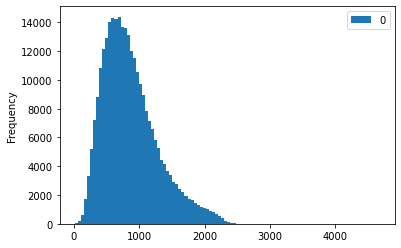

In [ ]:
pd.DataFrame(tokenized_articles_lens).plot(kind='hist', bins=100)
pd.DataFrame(tokenized_articles_lens).describe()

0
count  287113.000000
mean       67.692079
std        27.458405
min         7.000000
25%        51.000000
50%        64.000000
75%        78.000000
max      2428.000000

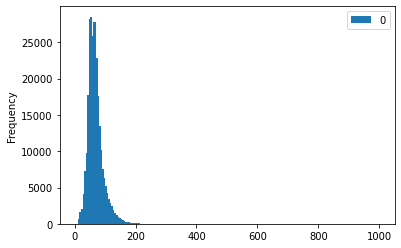

In [ ]:
pd.DataFrame(tokenized_highlights_lens).plot(kind='hist', bins=200, range=(1, 1000))
pd.DataFrame(tokenized_highlights_lens).describe()

### Preprocess input

In [ ]:
SRC_MAX_LENGTH = 512 #2200 
TRG_MAX_LENGTH = 64 #200 

def get_conditional_article(examples):
    prefix = ' '.join([X.text for X in ner_tagger(examples['article']).ents])
    conditional_article = f'{prefix} => {examples["article"]}'
    return conditional_article

def preprocess_function(examples):
    inputs = get_conditional_article(examples)
    model_inputs = tokenizer(inputs, max_length=SRC_MAX_LENGTH, padding='max_length', truncation=True, return_tensors='pt')

    labels = tokenizer(text_target=examples["highlights"], max_length=TRG_MAX_LENGTH, padding='max_length', truncation=True, return_tensors='pt')

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
from torch.utils.data import Dataset 

class CNNDailyDataset(Dataset):

    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx, squeeze_labels=True, drop_token_type_ids=False):
        model_input = preprocess_function(self.dataset[idx])
        if drop_token_type_ids:
            model_input.pop('token_type_ids')
        if squeeze_labels:
            model_input['labels'] = model_input['labels'].squeeze(0)
            model_input['attention_mask'] = model_input['attention_mask'].squeeze(0)
        return model_input

    def __len__(self):
        return len(self.dataset)

In [ ]:
td = CNNDailyDataset(dataset['train'])

## Train

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="results",
    # evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    # per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    fp16=True,
    report_to=None
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=td,
    # eval_dataset=tokenized_billsum["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

Using cuda_amp half precision backend


In [ ]:
trainer.train()

***** Running training *****
  Num examples = 1000
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 1500
  Number of trainable parameters = 406290432


Saving model checkpoint to results/checkpoint-500
Configuration saved in results/checkpoint-500/config.json
Model weights saved in results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in results/checkpoint-500/tokenizer_config.json
Special tokens file saved in results/checkpoint-500/special_tokens_map.json
Saving model checkpoint to results/checkpoint-1000
Configuration saved in results/checkpoint-1000/config.json
Model weights saved in results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in results/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to results/checkpoint-1500
Configuration saved in results/checkpoint-1500/config.json
Model weights saved in results/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in results/checkpoint-1500/tokenizer_config.json
Special tokens file saved in results/checkpoint-1500/special_tokens_map.json


Training complet

TrainOutput(global_step=1500, training_loss=2.6085472005208334, metrics={'train_runtime': 901.2161, 'train_samples_per_second': 3.329, 'train_steps_per_second': 1.664, 'total_flos': 3250656903168000.0, 'train_loss': 2.6085472005208334, 'epoch': 3.0})

# Model evaluation

In [ ]:
rouge = evaluate.load('rouge')

In [ ]:
def get_rouge_on_sample(example):
    try:
        reference = example['highlights']
        output_ids = model.generate(tokenizer(get_conditional_article(example), max_length=SRC_MAX_LENGTH, padding=True, truncation=True, return_tensors='pt').input_ids, max_length=TRG_MAX_LENGTH)[0]
        prediction = tokenizer.decode(output_ids, skip_special_tokens=True)
        scores = rouge.compute(predictions=[prediction], references=[reference])
    except:
        scores = None
    return scores

In [ ]:
def get_kfolds(n, fold_size, df: pd.DataFrame):
    folds = [df.sample(n=fold_size) for _ in tqdm.tqdm(range(n))]
    return folds

In [ ]:
def get_fold_mean_metric(folds, metric):
    scores = [fold[metric].mean() for fold in folds]
    return scores

In [ ]:
df.to_csv('achi.csv', index=False)

In [ ]:
df = pd.DataFrame(dataset['validation'].map(get_rouge_on_sample))

  0%|          | 0/100 [00:00<?, ?ex/s]

In [ ]:
k_folds = get_kfolds(n=500, fold_size=50, df=df)

100%|██████████| 500/500 [00:00<00:00, 4052.55it/s]


In [ ]:
rouge1 = get_fold_mean_metric(folds=k_folds, metric='rouge1')
rouge2 = get_fold_mean_metric(folds=k_folds, metric='rouge2')
rougeL = get_fold_mean_metric(folds=k_folds, metric='rougeL')
rougeLsum = get_fold_mean_metric(folds=k_folds, metric='rougeLsum')

In [ ]:
df_to_plot = pd.DataFrame({'rouge1': rouge1, 'rouge2': rouge2, 'rougeL': rougeL, 'rougeLsum': rougeLsum})

[]

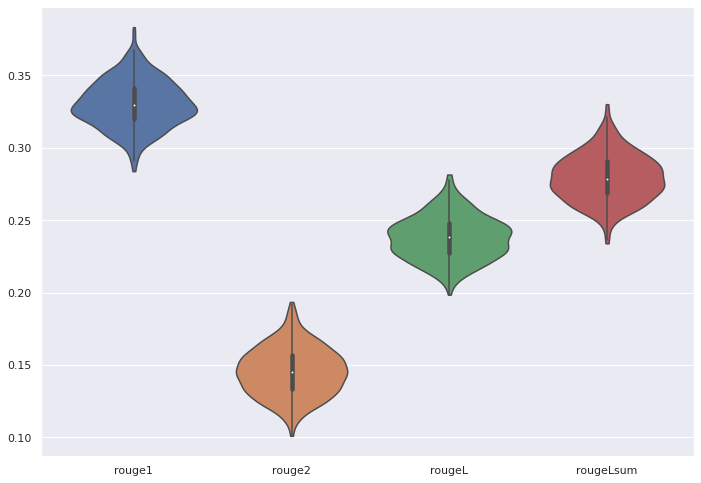

In [ ]:
ax = sns.violinplot(data=df_to_plot, cut=0, inner='box')
ax.plot()

# Explain model behaviour

In [ ]:
article = get_conditional_article(dataset['test'][0])

In [ ]:
explainer = shap.Explainer(model, tokenizer)

In [ ]:
shap_values = explainer([article])

Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:51, 51.60s/it]               


In [ ]:
shap.plots.text(shap_values)

# References

- Summarization Methods: 
    - https://www.ijert.org/research/text-summarizer-using-abstractive-and-extractive-method-IJERTV3IS050821.pdf
    - https://www.prodigaltech.com/blog/extractive-vs-abstractive-summarization-how-does-it-work
- Data Preparation
    - https://github.com/nipunsadvilkar/pySBD
    - https://arxiv.org/abs/2010.09657
- Model Fine-Tuning
    - https://dspace.cvut.cz/bitstream/handle/10467/87671/F3-BP-2020-Muller-Stepan-text_summarization_using_named_entity_recognition.pdf
    - https://pythonprogramming.net/named-entity-recognition-stanford-ner-tagger/
    - https://github.com/salesforce/ctrl-sum#option-3-through-huggingface-transformers
    -https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da
    -https://huggingface.co/docs/transformers/tasks/summarization
- Explain model behaviour
    - https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/summarization/Abstractive%20Summarization%20Explanation%20Demo.html
    - https://arxiv.org/pdf/2205.13662.pdf